## Import Library

In [1]:
!pip install Sastrawi
!pip install wordcloud
!pip install --upgrade scikit-learn imbalanced-learn
!pip install transformers
!pip install torch

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib

from collections import Counter
from wordcloud import WordCloud

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Pastikan nltk resources sudah diunduh
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

import transformers
import random


import warnings
warnings.simplefilter('ignore')

scaler = torch.cuda.amp.GradScaler()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from collections import Counter

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [11]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [12]:
!pwd

/content/drive/MyDrive


In [13]:
!mkdir project_spam
%cd /content/drive/MyDrive/project_spam

/content/drive/MyDrive/project_spam


## Collecting Dataset

Dataset:

* [SMS Spam Filtering: New Collection and Results](https://huggingface.co/datasets/ucirvine/sms_spam)

In [ ]:
df = pd.read_parquet("hf://datasets/ucirvine/sms_spam/plain_text/train-00000-of-00001.parquet")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sms     5574 non-null   object
 1   label   5574 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [ ]:
df.head()

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [ ]:
df = df.rename(columns={"label": "Category", "sms": "Message"})

In [ ]:
df.Category = df.Category.map({0: "ham", 1: "spam"})

In [ ]:
df.head()

,Message,Category
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...\n,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [ ]:
df.to_csv("spam_dataset.csv", index=False)

**Dataset:**
1. [spam_dataset_idn.csv](https://drive.google.com/uc?export=download&id=13JdlK_0QMMgiHyE3JDwU1lcpc2UMErR5)
2. [dataset_sms_spam_v2.csv](https://gist.githubusercontent.com/agtbaskara/a1a7017027cc1df9d35cf06e1e5575b7/raw/59870e27ca217d77ac0d8d8dc100551c0dcd14b3/dataset_sms_spam_v2.csv)


In [ ]:
df_idn = pd.read_csv("https://drive.google.com/uc?export=download&id=1yiwZrYdbY4RafbVrVEgKhHKi0cXpFeWH")

In [ ]:
df_idn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Message   5574 non-null   object
 1   Category  5574 non-null   object
 2   Bahasa    5574 non-null   object
dtypes: object(3)
memory usage: 130.8+ KB


In [ ]:
df_idn.drop(columns=["Message"], axis=1, inplace=True)

In [ ]:
df_idn.head()

,Category,Bahasa
0,ham,"Pergi sampai jurong point, gila.. Hanya tersed..."
1,ham,Ok lar... Bercanda denganmu oni...\n
2,spam,Entri gratis dalam 2 minggu berturut-turut unt...
3,ham,"Kamu tak bilang pagi-pagi sekali, hor... Kamu ..."
4,ham,"Tidak, menurutku dia tidak pergi ke usf, dia t..."


In [ ]:
df_git = pd.read_csv('https://gist.githubusercontent.com/agtbaskara/a1a7017027cc1df9d35cf06e1e5575b7/raw/59870e27ca217d77ac0d8d8dc100551c0dcd14b3/dataset_sms_spam_v2.csv')
df_git.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Teks    1143 non-null   object
 1   label   1143 non-null   object
dtypes: object(2)
memory usage: 18.0+ KB


In [ ]:
df_git.label.value_counts()

,count
label,
normal,569
penipuan,335
promo,239


In [ ]:
df_git = df_git.rename(columns={"label": "Category", "Teks": "Bahasa"})
df_git.Category = df_git.Category.map({"normal": "ham", "penipuan": "spam", "promo": "spam"})

In [ ]:
df_git.Category.value_counts()

,count
Category,
spam,574
ham,569


In [ ]:
df = pd.concat([df_idn, df_git])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6717 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  6717 non-null   object
 1   Bahasa    6717 non-null   object
dtypes: object(2)
memory usage: 157.4+ KB


In [ ]:
df.Category[df.duplicated()].value_counts()

,count
Category,
ham,315
spam,96


In [ ]:
df.drop_duplicates(inplace = True)
df.duplicated().sum()

0

## Pre-Processing Data

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words('indonesian'))

def cleaningText(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'#[A-Za-z0-9]+', ' ', text)
    text = re.sub(r"http\S+", ' ', text)
    text = text.replace('\n', ' ')
    text = text.strip(' ')
    return text

def tokenizingText(text):
    return word_tokenize(text)

def filteringText(text):
    return [word for word in text if word not in stop_words]

def stemmingText(text):
    return [stemmer.stem(word) for word in text]

def toSentence(list_words):
    return ' '.join(word for word in list_words)

def preprocess_text(text):
    text = cleaningText(text)
    text = tokenizingText(text)
    text = filteringText(text)
    text = stemmingText(text)
    text = toSentence(text)
    return text

In [ ]:
df['Cleaned_Bahasa'] = df['Bahasa'].apply(preprocess_text)

In [ ]:
df.Category.value_counts()

,count
Category,
ham,5081
spam,1225


In [ ]:
df.head()

,Category,Bahasa,Cleaned_Bahasa
0,ham,"Pergi sampai jurong point, gila.. Hanya tersed...",pergi jurong point gila sedia bugis n great wo...
1,ham,Ok lar... Bercanda denganmu oni...\n,ok lar canda dengan oni
2,spam,Entri gratis dalam 2 minggu berturut-turut unt...,entri gratis minggu menang tkt final piala fa ...
3,ham,"Kamu tak bilang pagi-pagi sekali, hor... Kamu ...",bilang pagi pagi hor bilang
4,ham,"Tidak, menurutku dia tidak pergi ke usf, dia t...",turut pergi usf tinggal


In [ ]:
df['Length'] = df['Cleaned_Bahasa'].apply(len)
df['Count'] = df['Cleaned_Bahasa'].apply(lambda x: len(x.split()))

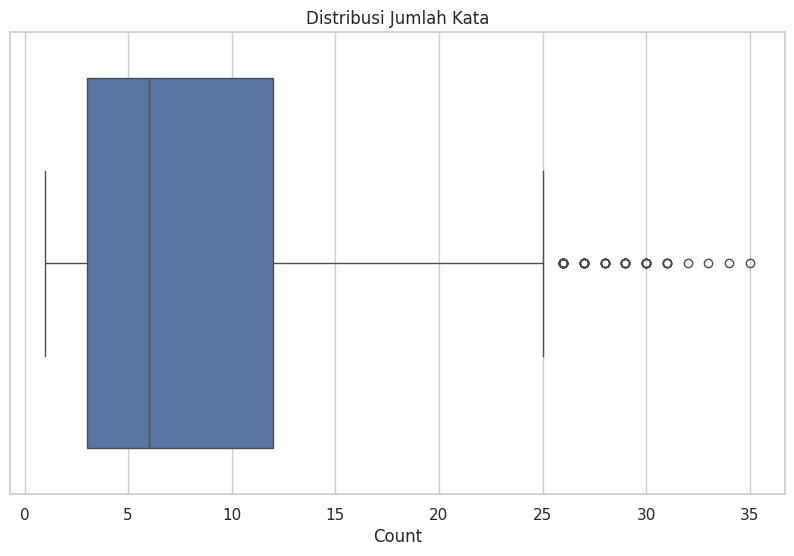

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Visualisasi distribusi jumlah kata
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Count'])
plt.title('Distribusi Jumlah Kata')
plt.show()

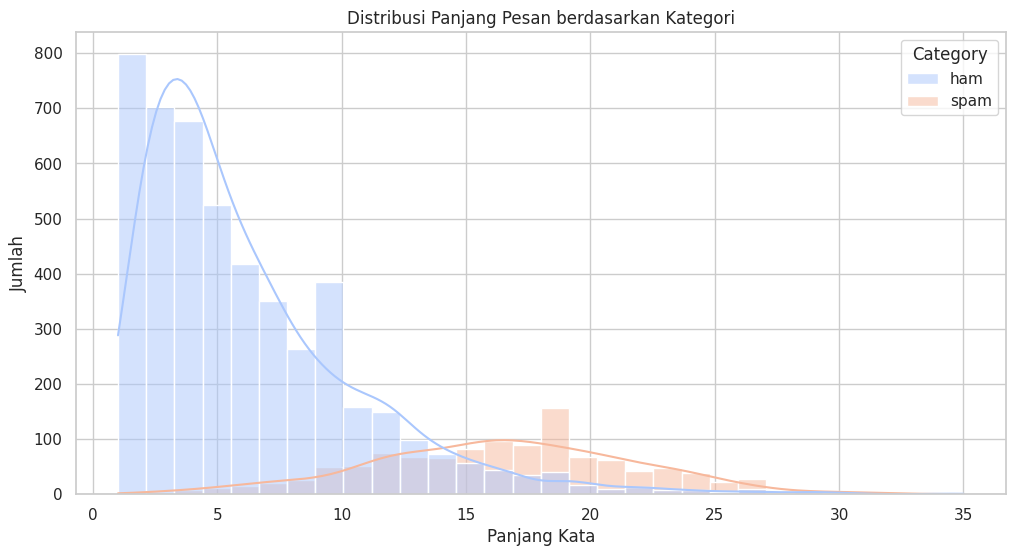

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Count', hue='Category', kde=True, bins=30, palette='coolwarm')
plt.title('Distribusi Panjang Pesan berdasarkan Kategori')
plt.xlabel('Panjang Kata')
plt.ylabel('Jumlah')
plt.show()

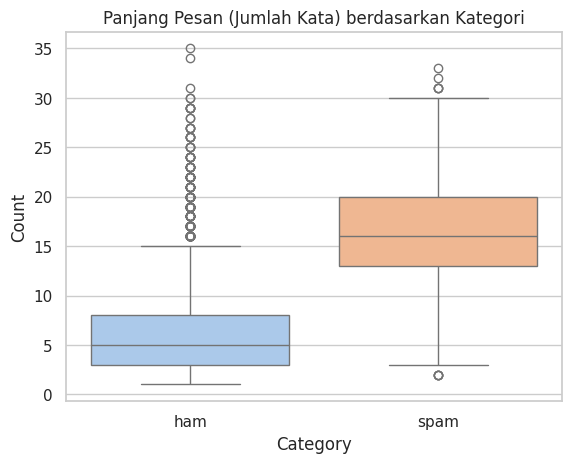

In [ ]:
sns.boxplot(data=df, x='Category', y='Count', palette='pastel')
plt.title('Panjang Pesan (Jumlah Kata) berdasarkan Kategori')
plt.show()

In [ ]:
# Menyaring data yang tidak termasuk outlier
df_filtered = df[(df['Count'] >= 1) & (df['Count'] <= 35)]
df_filtered.Category.value_counts()

,count
Category,
ham,5011
spam,1212


In [ ]:
df_filtered.head()

,Category,Bahasa,Cleaned_Bahasa,Length,Count
0,ham,"Pergi sampai jurong point, gila.. Hanya tersed...",pergi jurong point gila sedia bugis n great wo...,86,17
1,ham,Ok lar... Bercanda denganmu oni...\n,ok lar canda dengan oni,23,5
2,spam,Entri gratis dalam 2 minggu berturut-turut unt...,entri gratis minggu menang tkt final piala fa ...,103,21
3,ham,"Kamu tak bilang pagi-pagi sekali, hor... Kamu ...",bilang pagi pagi hor bilang,27,5
4,ham,"Tidak, menurutku dia tidak pergi ke usf, dia t...",turut pergi usf tinggal,23,4


In [ ]:
df_filtered.to_csv("spam_dataset_idn_clean.csv", index=False)

## Visualization

Dataset:
* [spam_dataset_idn_clean.csv](https://drive.google.com/uc?export=download&id=1vHGFLJHs_w1Uq6O0IiaHQvvsexSAG2GQ)

In [ ]:
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1vHGFLJHs_w1Uq6O0IiaHQvvsexSAG2GQ')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6223 entries, 0 to 6222
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Category        6223 non-null   object
 1   Bahasa          6223 non-null   object
 2   Cleaned_Bahasa  6223 non-null   object
 3   Length          6223 non-null   int64 
 4   Count           6223 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 243.2+ KB


In [ ]:
df.head()

,Category,Bahasa,Cleaned_Bahasa,Length,Count
0,ham,"Pergi sampai jurong point, gila.. Hanya tersed...",pergi jurong point gila sedia bugis n great wo...,86,17
1,ham,Ok lar... Bercanda denganmu oni...\n,ok lar canda dengan oni,23,5
2,spam,Entri gratis dalam 2 minggu berturut-turut unt...,entri gratis minggu menang tkt final piala fa ...,103,21
3,ham,"Kamu tak bilang pagi-pagi sekali, hor... Kamu ...",bilang pagi pagi hor bilang,27,5
4,ham,"Tidak, menurutku dia tidak pergi ke usf, dia t...",turut pergi usf tinggal,23,4


In [ ]:
df.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Category,6223,2,ham,5011,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bahasa,6223,6223,"Pergi sampai jurong point, gila.. Hanya tersed...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cleaned_Bahasa,6223,6002,laku,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Length,6223.0,NaN,NaN,NaN,45.001286,34.142336,1.0,18.0,34.0,67.0,192.0
Count,6223.0,NaN,NaN,NaN,8.063635,6.148604,1.0,3.0,6.0,12.0,35.0


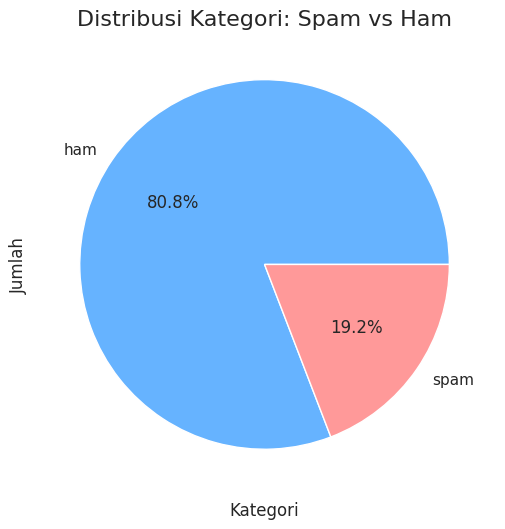

In [ ]:
# Menentukan warna untuk setiap kategori
custom_colors = ['#66b3ff', '#ff9999']  # Warna pastel biru untuk ham, merah untuk spam

# Membuat bar chart
plt.figure(figsize=(8, 6))
plt.pie(df.Category.value_counts().values, labels=df.Category.value_counts().index, autopct='%1.1f%%', colors=custom_colors)
plt.title('Distribusi Kategori: Spam vs Ham', fontsize=16)
plt.xlabel('Kategori')
plt.ylabel('Jumlah')
plt.show()

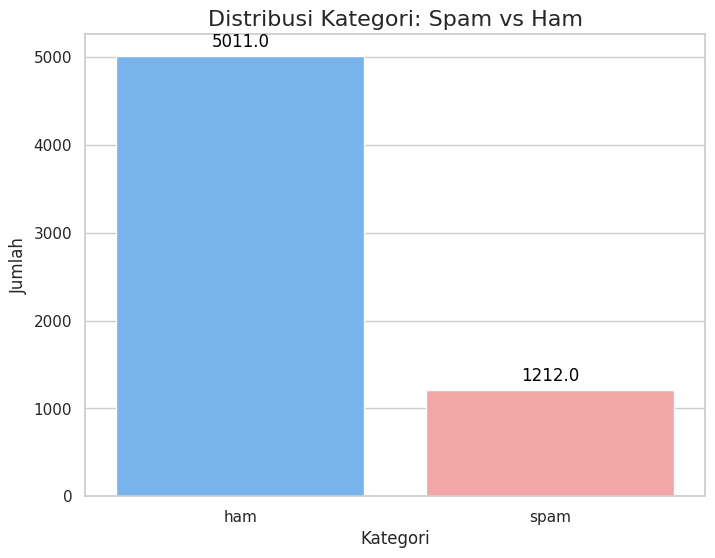

In [ ]:
# Menghitung distribusi kategori
category_counts = df['Category'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Membuat bar chart
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=category_counts, x='Category', y='Count', hue='Category', palette={'ham': '#66b3ff', 'spam': '#ff9999'}, dodge=False)

# Menambahkan nilai count di atas setiap batang
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 10), textcoords='offset points')

# Menonaktifkan legenda
plt.legend([], [], frameon=False)

# Menambahkan judul dan label
plt.title('Distribusi Kategori: Spam vs Ham', fontsize=16)
plt.xlabel('Kategori')
plt.ylabel('Jumlah')
plt.show()

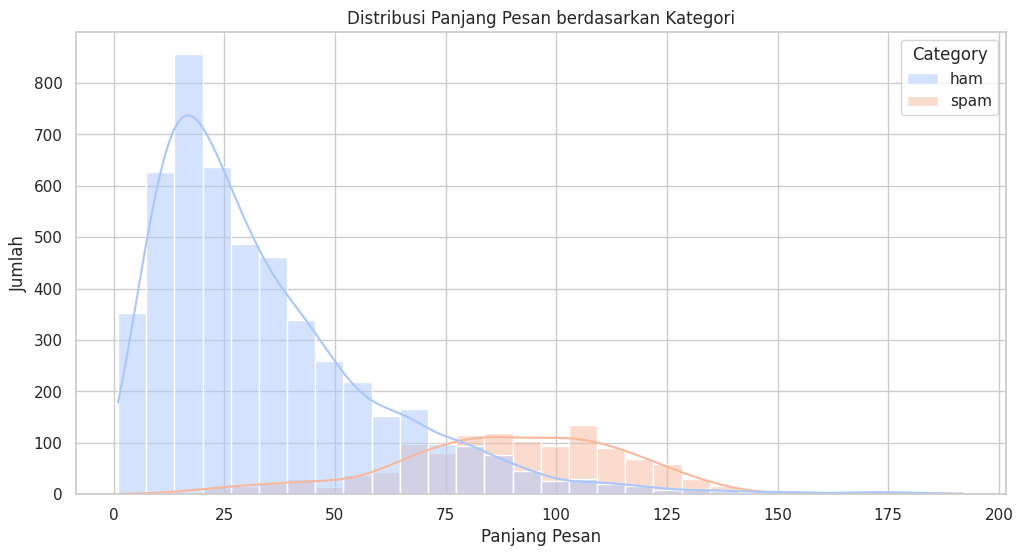

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Length', hue='Category', kde=True, bins=30, palette='coolwarm')
plt.title('Distribusi Panjang Pesan berdasarkan Kategori')
plt.xlabel('Panjang Pesan')
plt.ylabel('Jumlah')
plt.show()

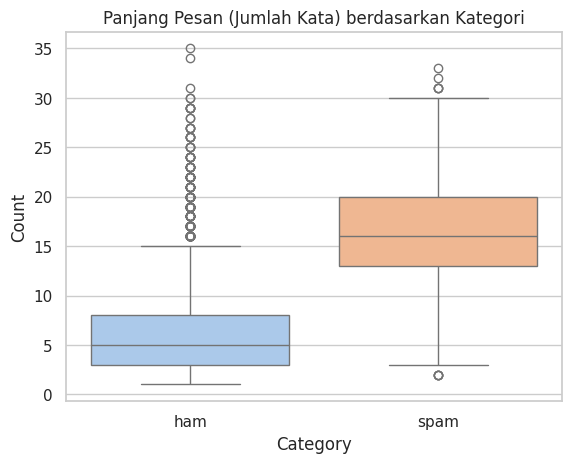

In [ ]:
sns.boxplot(data=df, x='Category', y='Count', palette='pastel')
plt.title('Panjang Pesan (Jumlah Kata) berdasarkan Kategori')
plt.show()

In [ ]:
spam_words = ' '.join(df[df['Category'] == 'spam']['Cleaned_Bahasa']).split()
ham_words = ' '.join(df[df['Category'] == 'ham']['Cleaned_Bahasa']).split()

spam_common = Counter(spam_words).most_common(10)
ham_common = Counter(ham_words).most_common(10)

print('Kata-kata paling umum dalam Spam:', spam_common)
print('Kata-kata paling umum dalam Ham:', ham_common)

Kata-kata paling umum dalam Spam: [('hubung', 376), ('gratis', 269), ('www', 252), ('sms', 241), ('hadiah', 240), ('info', 240), ('com', 209), ('menang', 201), ('kirim', 195), ('no', 180)]
Kata-kata paling umum dalam Ham: [('ya', 367), ('jam', 312), ('kirim', 298), ('malam', 296), ('gt', 270), ('lt', 259), ('pergi', 242), ('sayang', 242), ('telepon', 214), ('oke', 208)]


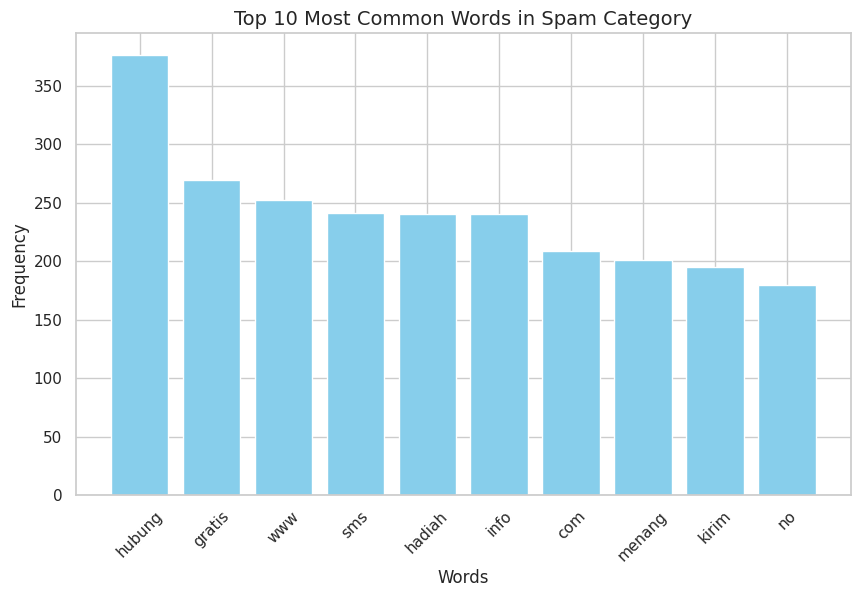

In [ ]:
word_freq = Counter(" ".join(df.Cleaned_Bahasa[df.Category == 'spam']).split())
common_words = word_freq.most_common(10)

# Pisahkan kata dan frekuensi untuk visualisasi
words, frequencies = zip(*common_words)

# Plot barchart
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies, color='skyblue')
plt.title('Top 10 Most Common Words in Spam Category', fontsize=14)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.show()

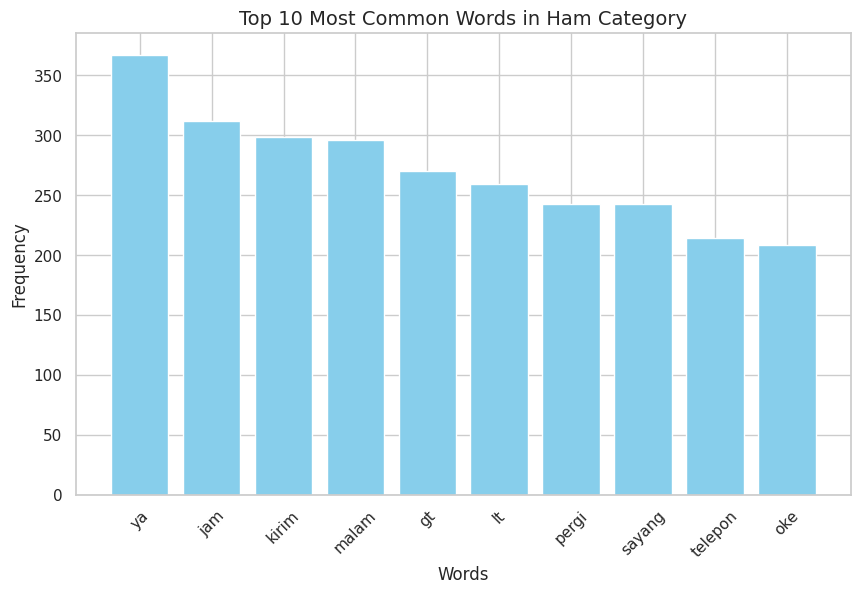

In [ ]:
word_freq = Counter(" ".join(df.Cleaned_Bahasa[df.Category == 'ham']).split())
common_words = word_freq.most_common(10)

# Pisahkan kata dan frekuensi untuk visualisasi
words, frequencies = zip(*common_words)

# Plot barchart
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies, color='skyblue')
plt.title('Top 10 Most Common Words in Ham Category', fontsize=14)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.show()

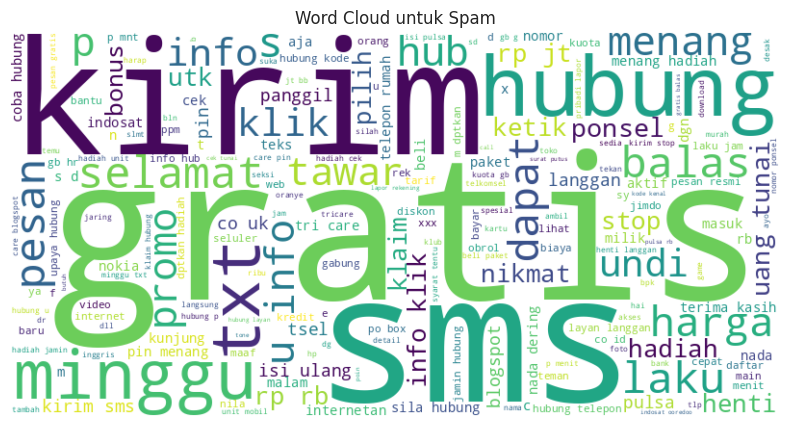

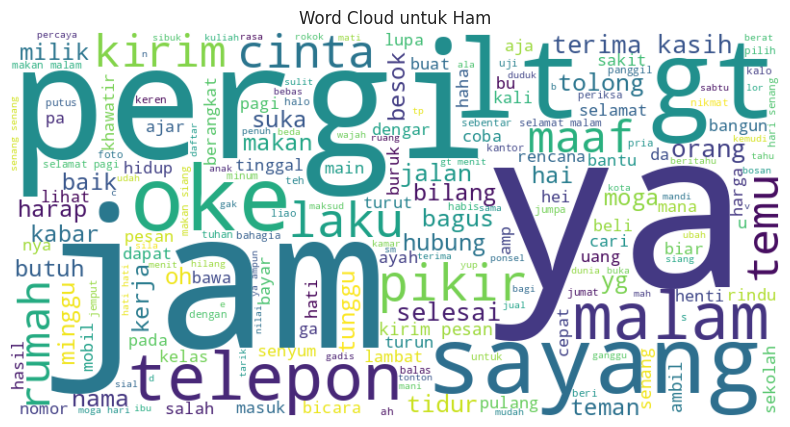

In [ ]:
spam_cloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(spam_words))
ham_cloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(ham_words))

plt.figure(figsize=(10, 5))
plt.imshow(spam_cloud, interpolation='bilinear')
plt.title('Word Cloud untuk Spam')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(ham_cloud, interpolation='bilinear')
plt.title('Word Cloud untuk Ham')
plt.axis('off')
plt.show()


## Feature Extraction

In [14]:
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1vHGFLJHs_w1Uq6O0IiaHQvvsexSAG2GQ')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6223 entries, 0 to 6222
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Category        6223 non-null   object
 1   Bahasa          6223 non-null   object
 2   Cleaned_Bahasa  6223 non-null   object
 3   Length          6223 non-null   int64 
 4   Count           6223 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 243.2+ KB


In [ ]:
df.Category[df.Cleaned_Bahasa.duplicated()].value_counts()

,count
Category,
ham,159
spam,62


In [15]:
df.drop(columns=["Bahasa"], axis=1, inplace=True)
df.dropna(inplace = True)
df.drop_duplicates(keep='first', inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6002 entries, 0 to 6222
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Category        6002 non-null   object
 1   Cleaned_Bahasa  6002 non-null   object
 2   Length          6002 non-null   int64 
 3   Count           6002 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 234.5+ KB


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Cleaned_Bahasa']).toarray()

In [17]:
from sklearn.model_selection import train_test_split

X = tfidf_matrix  # atau BoW/embeddings lainnya
y = df['Category']  # Label kategori, misalnya 'spam' atau 'ham'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Modeling and Training

In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.9633638634471274


## Evaluation

In [ ]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.96      0.99      0.98       983
        spam       0.96      0.83      0.89       218

    accuracy                           0.96      1201
   macro avg       0.96      0.91      0.94      1201
weighted avg       0.96      0.96      0.96      1201

[[975   8]
 [ 36 182]]


In [19]:
import joblib
%mkdir spam_model

joblib.dump(model, 'spam_model//spam_model.pkl')
joblib.dump(tfidf_vectorizer, 'spam_model//tfidf_vectorizer.pkl')

['spam_model//tfidf_vectorizer.pkl']

## Testing Deplyoment

In [ ]:
# Load model dan vectorizer
model_load = joblib.load('spam_model//spam_model.pkl')  # Path ke model yang disimpan
vectorizer_load = joblib.load('spam_model//tfidf_vectorizer.pkl')  # Path ke vectorizer yang disimpan

In [27]:
def preprocess_text(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Lowercase
    text = text.lower()

    # Hapus karakter khusus kecuali angka dan spasi
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'#[A-Za-z0-9]+', ' ', text)
    text = re.sub(r"http\S+", ' ', text)
    text = text.replace('\n', ' ')
    text = text.strip(' ')

    # Tokenisasi
    tokens = word_tokenize(text)

    # Stemming
    tokens = [stemmer.stem(word) for word in tokens]

    # Gabungkan kembali menjadi teks
    text = ' '.join(tokens)

    return text

In [ ]:
# Fungsi untuk prediksi input user
def predict_user_input(input_text, model_load, vectorizer_load):
    # Preprocessing
    cleaned_text = preprocess_text(input_text)

    # Transformasi teks menjadi bentuk numerik
    vectorized_text = vectorizer_load.transform([cleaned_text])

    # Prediksi menggunakan model
    prediction = model_load.predict(vectorized_text)

    # Kembalikan hasil prediksi
    return prediction[0]

In [ ]:
result = predict_user_input('Hai, perkenalkan aku Farhan', model_load, vectorizer_load)
print(f"Hasil Prediksi: {result}")

Hasil Prediksi: ham


In [ ]:
data_dummy_spam = [
        "Selamat! Anda telah memenangkan hadiah undian sebesar 10 juta rupiah. Hubungi kami di nomor ini atau kunjungi www.hadiah-anda-gratis.com segera.",
        "Dapatkan diskon eksklusif hingga 80% untuk produk pilihan kami hanya hari ini. Kunjungi www.promohariini.com untuk info lebih lanjut.",
        "Ayo tingkatkan peluang Anda memenangkan hadiah besar dengan mengikuti survei singkat kami. Klik tautan www.kesempatanemas.com sekarang!",
        "Penawaran spesial terbatas! Dapatkan pinjaman hingga 100 juta tanpa jaminan. Kirim informasi Anda melalui SMS ke 123456 untuk pengajuan cepat.",
        "Liburan impian Anda menunggu! Pesan sekarang dan nikmati potongan harga besar dengan hanya sekali klik di www.liburangratis.com.",
        "Peringatan! Akun Anda terdeteksi aktivitas mencurigakan. Segera perbarui informasi dengan klik www.keamananakun.com agar tetap aman.",
        "Mau gadget baru? Ikuti program undian kami dan menangkan smartphone impian Anda! Hubungi kami di nomor ini segera.",
        "Jangan lewatkan promo spesial akhir tahun kami! Gratis ongkos kirim untuk semua pembelian hari ini saja. Pesan sekarang di www.promo-gratis.com.",
        "Tingkatkan kesehatan Anda dengan produk herbal berkualitas. Promo diskon hingga 50% hanya tersedia di www.herbalpilihan.com.",
        "Kami telah memilih Anda sebagai pemenang hadiah eksklusif! Segera isi formulir klaim di www.hadiahkhusus.com sebelum batas waktu habis."
    ]

# Contoh uji prediksi dengan data dummy
for text in data_dummy_spam:
    result = predict_user_input(text, model_load, vectorizer_load)
    print(f"Teks: {text}\nPrediksi: {result}\n")

Teks: Selamat! Anda telah memenangkan hadiah undian sebesar 10 juta rupiah. Hubungi kami di nomor ini atau kunjungi www.hadiah-anda-gratis.com segera.
Prediksi: spam

Teks: Dapatkan diskon eksklusif hingga 80% untuk produk pilihan kami hanya hari ini. Kunjungi www.promohariini.com untuk info lebih lanjut.
Prediksi: spam

Teks: Ayo tingkatkan peluang Anda memenangkan hadiah besar dengan mengikuti survei singkat kami. Klik tautan www.kesempatanemas.com sekarang!
Prediksi: spam

Teks: Penawaran spesial terbatas! Dapatkan pinjaman hingga 100 juta tanpa jaminan. Kirim informasi Anda melalui SMS ke 123456 untuk pengajuan cepat.
Prediksi: spam

Teks: Liburan impian Anda menunggu! Pesan sekarang dan nikmati potongan harga besar dengan hanya sekali klik di www.liburangratis.com.
Prediksi: spam

Teks: Peringatan! Akun Anda terdeteksi aktivitas mencurigakan. Segera perbarui informasi dengan klik www.keamananakun.com agar tetap aman.
Prediksi: spam

Teks: Mau gadget baru? Ikuti program undian kami

## SMOTE

In [20]:
from imblearn.over_sampling import SMOTE

# Convert sparse matrix to dense
X_train_dense = X_train

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_dense, y_train)

In [21]:
print("Sebelum SMOTE:", Counter(y_train))
print("Setelah SMOTE:", Counter(y_train_resampled))

Sebelum SMOTE: Counter({'ham': 3869, 'spam': 932})
Setelah SMOTE: Counter({'ham': 3869, 'spam': 3869})


In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

model = MultinomialNB()

# Train model
model = MultinomialNB()
model.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9450457951706911
              precision    recall  f1-score   support

         ham       0.99      0.95      0.97       983
        spam       0.79      0.94      0.86       218

    accuracy                           0.95      1201
   macro avg       0.89      0.95      0.91      1201
weighted avg       0.95      0.95      0.95      1201

[[929  54]
 [ 12 206]]


In [23]:
import joblib

joblib.dump(model, 'spam_model//spam_model_smote.pkl')
joblib.dump(tfidf_vectorizer, 'spam_model//tfidf_vectorizer_smote.pkl')

['spam_model//tfidf_vectorizer_smote.pkl']

In [24]:
# Load model dan vectorizer
model_load_smote = joblib.load('spam_model//spam_model_smote.pkl')  # Path ke model yang disimpan
vectorizer_load_smote = joblib.load('spam_model//tfidf_vectorizer_smote.pkl')  # Path ke vectorizer yang disimpan

In [25]:
# Fungsi untuk prediksi input user
def predict_user_input_smote(input_text, model, vectorizer_load):
    # Preprocessing
    cleaned_text = preprocess_text(input_text)

    # Transformasi teks menjadi bentuk numerik
    vectorized_text = vectorizer_load.transform([cleaned_text])

    # Prediksi menggunakan model
    prediction = model.predict(vectorized_text)

    # Kembalikan hasil prediksi
    return prediction[0]

In [28]:
data_dummy_spam = [
        "Selamat! Anda telah memenangkan hadiah undian sebesar 10 juta rupiah. Hubungi kami di nomor ini atau kunjungi www.hadiah-anda-gratis.com segera.",
        "Dapatkan diskon eksklusif hingga 80% untuk produk pilihan kami hanya hari ini. Kunjungi www.promohariini.com untuk info lebih lanjut.",
        "Ayo tingkatkan peluang Anda memenangkan hadiah besar dengan mengikuti survei singkat kami. Klik tautan www.kesempatanemas.com sekarang!",
        "Penawaran spesial terbatas! Dapatkan pinjaman hingga 100 juta tanpa jaminan. Kirim informasi Anda melalui SMS ke 123456 untuk pengajuan cepat.",
        "Liburan impian Anda menunggu! Pesan sekarang dan nikmati potongan harga besar dengan hanya sekali klik di www.liburangratis.com.",
        "Peringatan! Akun Anda terdeteksi aktivitas mencurigakan. Segera perbarui informasi dengan klik www.keamananakun.com agar tetap aman.",
        "Mau gadget baru? Ikuti program undian kami dan menangkan smartphone impian Anda! Hubungi kami di nomor ini segera.",
        "Jangan lewatkan promo spesial akhir tahun kami! Gratis ongkos kirim untuk semua pembelian hari ini saja. Pesan sekarang di www.promo-gratis.com.",
        "Tingkatkan kesehatan Anda dengan produk herbal berkualitas. Promo diskon hingga 50% hanya tersedia di www.herbalpilihan.com.",
        "Kami telah memilih Anda sebagai pemenang hadiah eksklusif! Segera isi formulir klaim di www.hadiahkhusus.com sebelum batas waktu habis."
    ]

# Contoh uji prediksi dengan data dummy
for text in data_dummy_spam:
    result = predict_user_input_smote(text, model_load_smote, vectorizer_load_smote)
    print(f"Teks: {text}\nPrediksi: {result}\n")

Teks: Selamat! Anda telah memenangkan hadiah undian sebesar 10 juta rupiah. Hubungi kami di nomor ini atau kunjungi www.hadiah-anda-gratis.com segera.
Prediksi: spam

Teks: Dapatkan diskon eksklusif hingga 80% untuk produk pilihan kami hanya hari ini. Kunjungi www.promohariini.com untuk info lebih lanjut.
Prediksi: spam

Teks: Ayo tingkatkan peluang Anda memenangkan hadiah besar dengan mengikuti survei singkat kami. Klik tautan www.kesempatanemas.com sekarang!
Prediksi: spam

Teks: Penawaran spesial terbatas! Dapatkan pinjaman hingga 100 juta tanpa jaminan. Kirim informasi Anda melalui SMS ke 123456 untuk pengajuan cepat.
Prediksi: spam

Teks: Liburan impian Anda menunggu! Pesan sekarang dan nikmati potongan harga besar dengan hanya sekali klik di www.liburangratis.com.
Prediksi: spam

Teks: Peringatan! Akun Anda terdeteksi aktivitas mencurigakan. Segera perbarui informasi dengan klik www.keamananakun.com agar tetap aman.
Prediksi: spam

Teks: Mau gadget baru? Ikuti program undian kami

## Transfer Learning + Deep Learning

In [ ]:
X = df['Cleaned_Bahasa'].tolist()
y = df['Category'].map({'ham': 0, 'spam': 1})

In [ ]:
# Membagi dataset menjadi data pelatihan dan pengujian
train_texts, test_texts, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=111)

In [ ]:
from transformers import BertTokenizer, TFBertModel

# Menggunakan tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=64)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=64)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Membuat dataset TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

In [ ]:
from transformers import BertForSequenceClassification

# Memuat model BERT untuk klasifikasi teks (contoh: sentimen positif/negatif)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.to(device)
model.train()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
from transformers import BertTokenizer
from torch.utils.data import DataLoader, TensorDataset

# Tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenisasi
train_encodings = tokenizer(train_texts, padding=True, truncation=True, return_tensors='pt')
test_encodings = tokenizer(test_texts, padding=True, truncation=True, return_tensors='pt')
train_encodings['labels'] = torch.tensor(train_labels.tolist(), dtype=torch.long)
test_encodings['labels'] = torch.tensor(test_labels.tolist(), dtype=torch.long)

# Membuat TensorDataset
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_encodings['token_type_ids'], train_encodings['labels'])
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_encodings['token_type_ids'], test_encodings['labels'])

# Membuat DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
valid_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


In [ ]:
for a in train_dataloader:
    # Asumsikan a adalah tuple, jadi kita akses dengan indeks numerik
    ids = a[0].to(device)  # input_ids berada di indeks ke-0
    mask = a[1].to(device)  # attention_mask berada di indeks ke-1
    tokentype = a[2].to(device)  # token_type_ids berada di indeks ke-2
    labels = a[3].to(device)  # labels berada di indeks ke-3

    output = model(ids, mask, token_type_ids=tokentype, labels=labels)
    break

In [ ]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

# Inisialisasi loss function dan optimizer
loss_fn = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=2e-5)

In [ ]:
# Cek bentuk data yang diterima dari DataLoader
for batch in train_dataloader:
    print(batch)
    break

[tensor([[  101, 17710,  8523,  ...,     0,     0,     0],
        [  101,  1037, 17560,  ...,     0,     0,     0],
        [  101,  8292,  3654,  ...,     0,     0,     0],
        ...,
        [  101,  2951,  3070,  ...,     0,     0,     0],
        [  101, 22854,  4890,  ...,     0,     0,     0],
        [  101,  2000, 10052,  ...,     0,     0,     0]]), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])]


In [ ]:
epochs = 10
for epoch in range(epochs):
    model.train()  # Set model ke mode training
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_dataloader:
        # Ambil input_ids, attention_mask, token_type_ids, dan label dari batch
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)  # Asumsi label berada di batch[3]

        # Forward pass
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Hitung akurasi
        predictions = torch.argmax(logits, dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)

        # Backward pass dan optimasi
        loss.backward()
        optimizer.step()

        # Tambahkan loss ke total_loss
        total_loss += loss.item()

    # Hitung rata-rata loss dan akurasi untuk epoch ini
    avg_loss = total_loss / len(train_dataloader)
    accuracy = correct_predictions / total_predictions
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch 1/10, Loss: 0.2584, Accuracy: 0.9002
Epoch 2/10, Loss: 0.1086, Accuracy: 0.9646
Epoch 3/10, Loss: 0.0626, Accuracy: 0.9813
Epoch 4/10, Loss: 0.0401, Accuracy: 0.9885
Epoch 5/10, Loss: 0.0325, Accuracy: 0.9913
Epoch 6/10, Loss: 0.0152, Accuracy: 0.9967
Epoch 7/10, Loss: 0.0164, Accuracy: 0.9960
Epoch 8/10, Loss: 0.0136, Accuracy: 0.9967
Epoch 9/10, Loss: 0.0104, Accuracy: 0.9967
Epoch 10/10, Loss: 0.0076, Accuracy: 0.9973


In [ ]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Set model ke mode evaluasi
model.eval()

total_correct = 0
total_samples = 0
all_predictions = []
all_labels = []

# Looping untuk batch data validasi
for batch in valid_dataloader:
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    token_type_ids = batch[2].to(device)
    labels = batch[3].to(device)

    with torch.no_grad():  # Nonaktifkan gradient computation untuk evaluasi
        outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
        logits = outputs.logits

    predictions = torch.argmax(logits, dim=1)

    # Menyimpan prediksi dan label untuk evaluasi
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

    total_correct += (predictions == labels).sum().item()
    total_samples += labels.size(0)

# Menghitung akurasi
accuracy = total_correct / total_samples
print(f"Validation Accuracy: {accuracy:.4f}")


Validation Accuracy: 0.9700


In [ ]:
# Menghitung classification report
report = classification_report(all_labels, all_predictions, target_names=['Ham', 'Spam'])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         Ham       0.99      0.98      0.98       976
        Spam       0.90      0.95      0.92       225

    accuracy                           0.97      1201
   macro avg       0.94      0.96      0.95      1201
weighted avg       0.97      0.97      0.97      1201



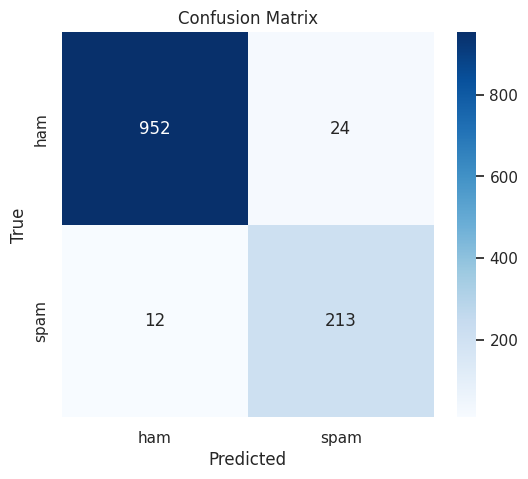

In [ ]:
# Menghitung confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Visualisasi confusion matrix dengan heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Simpan model yang sudah dilatih
torch.save(model.state_dict(), "bert_spam_ham_model.pth")
tokenizer.save_pretrained("bert_spam_ham_tokenizer")

('bert_spam_ham_tokenizer/tokenizer_config.json',
 'bert_spam_ham_tokenizer/special_tokens_map.json',
 'bert_spam_ham_tokenizer/vocab.txt',
 'bert_spam_ham_tokenizer/added_tokens.json',
 'bert_spam_ham_tokenizer/tokenizer.json')

In [ ]:
from transformers import AutoModelForSequenceClassification

# Initialize the model architecture
model_bert = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased").to(device)

# Load the state dictionary
model_bert.load_state_dict(torch.load("bert_spam_ham_model.pth"))

# Ensure the model is in evaluation mode
model_bert.eval()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
from transformers import AutoTokenizer

tokenizer_bert = AutoTokenizer.from_pretrained("bert_spam_ham_tokenizer")

In [ ]:
# Fungsi untuk melakukan prediksi
def predict(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    token_type_ids = inputs["token_type_ids"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        logits = outputs.logits

    prediction = torch.argmax(logits, dim=1).item()  # 0 = ham, 1 = spam
    return prediction

In [ ]:
# Contoh prediksi
text = 'halo selamat pagi, aku Farhan'
prediction = predict(text, tokenizer_bert, model_bert)
label = "spam" if prediction == 1 else "ham"
print(f"Prediksi: {label}")

Prediksi: ham


In [ ]:
data_dummy_spam = [
        "Selamat! Anda telah memenangkan hadiah undian sebesar 10 juta rupiah. Hubungi kami di nomor ini atau kunjungi www.hadiah-anda-gratis.com segera.",
        "Dapatkan diskon eksklusif hingga 80% untuk produk pilihan kami hanya hari ini. Kunjungi www.promohariini.com untuk info lebih lanjut.",
        "Ayo tingkatkan peluang Anda memenangkan hadiah besar dengan mengikuti survei singkat kami. Klik tautan www.kesempatanemas.com sekarang!",
        "Penawaran spesial terbatas! Dapatkan pinjaman hingga 100 juta tanpa jaminan. Kirim informasi Anda melalui SMS ke 123456 untuk pengajuan cepat.",
        "Liburan impian Anda menunggu! Pesan sekarang dan nikmati potongan harga besar dengan hanya sekali klik di www.liburangratis.com.",
        "Peringatan! Akun Anda terdeteksi aktivitas mencurigakan. Segera perbarui informasi dengan klik www.keamananakun.com agar tetap aman.",
        "Mau gadget baru? Ikuti program undian kami dan menangkan smartphone impian Anda! Hubungi kami di nomor ini segera.",
        "Jangan lewatkan promo spesial akhir tahun kami! Gratis ongkos kirim untuk semua pembelian hari ini saja. Pesan sekarang di www.promo-gratis.com.",
        "Tingkatkan kesehatan Anda dengan produk herbal berkualitas. Promo diskon hingga 50% hanya tersedia di www.herbalpilihan.com.",
        "Kami telah memilih Anda sebagai pemenang hadiah eksklusif! Segera isi formulir klaim di www.hadiahkhusus.com sebelum batas waktu habis."
    ]
# Contoh uji prediksi dengan data dummy
for text in data_dummy_spam:
    prediction = predict(text, tokenizer_bert, model_bert)
    label = "spam" if prediction == 1 else "ham"
    print(f"Prediksi: {label}")

Prediksi: spam
Prediksi: spam
Prediksi: spam
Prediksi: ham
Prediksi: spam
Prediksi: spam
Prediksi: spam
Prediksi: spam
Prediksi: spam
Prediksi: spam


## BERT + LSTM

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

class BERT_LSTM_Model(nn.Module):
    def __init__(self, bert_model_name, hidden_dim, num_classes):
        super(BERT_LSTM_Model, self).__init__()

        # Load pre-trained BERT model
        self.bert = BertModel.from_pretrained(bert_model_name)

        # LSTM layer
        self.lstm = nn.LSTM(input_size=self.bert.config.hidden_size,
                            hidden_size=hidden_dim,
                            batch_first=True,
                            bidirectional=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 karena bidirectional

    def forward(self, input_ids, attention_mask, token_type_ids):
        # Mendapatkan output dari BERT
        bert_output = self.bert(input_ids=input_ids,
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids)

        # Output BERT adalah (batch_size, sequence_length, hidden_size)
        sequence_output = bert_output.last_hidden_state

        # Menggunakan LSTM pada output dari BERT
        lstm_out, (hn, cn) = self.lstm(sequence_output)

        # Mengambil output dari LSTM (menggunakan hidden state terakhir)
        lstm_out_last = lstm_out[:, -1, :]  # Mengambil hidden state pada langkah terakhir

        # Menyambungkan dengan Fully Connected Layer untuk menghasilkan prediksi
        logits = self.fc(lstm_out_last)

        return logits

# Inisialisasi Model
model_blstm = BERT_LSTM_Model(bert_model_name='bert-base-uncased', hidden_dim=128, num_classes=2).to(device)

In [ ]:
optimizer = torch.optim.Adam(model_blstm.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 5

model_blstm.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        optimizer.zero_grad()

        # Forward pass
        logits = model_blstm(input_ids, attention_mask, token_type_ids)

        # Loss computation
        loss = loss_fn(logits, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


Epoch 1/5, Loss: 0.04128235951066017
Epoch 2/5, Loss: 0.006904315669089556
Epoch 3/5, Loss: 0.005785505287349224
Epoch 4/5, Loss: 0.011143354699015617
Epoch 5/5, Loss: 0.0029404994565993547


In [ ]:
model_blstm.eval()
total_correct = 0
total_samples = 0
all_predictions = []
all_labels = []

for batch in valid_dataloader:
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    token_type_ids = batch[2].to(device)
    labels = batch[3].to(device)

    with torch.no_grad():
        logits = model_blstm(input_ids, attention_mask, token_type_ids)

    predictions = torch.argmax(logits, dim=1)

    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

    total_correct += (predictions == labels).sum().item()
    total_samples += labels.size(0)

accuracy = total_correct / total_samples
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.9775


In [ ]:
report = classification_report(all_labels, all_predictions, target_names=['ham', 'spam'])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         ham       0.98      0.99      0.99       976
        spam       0.97      0.91      0.94       225

    accuracy                           0.98      1201
   macro avg       0.97      0.95      0.96      1201
weighted avg       0.98      0.98      0.98      1201



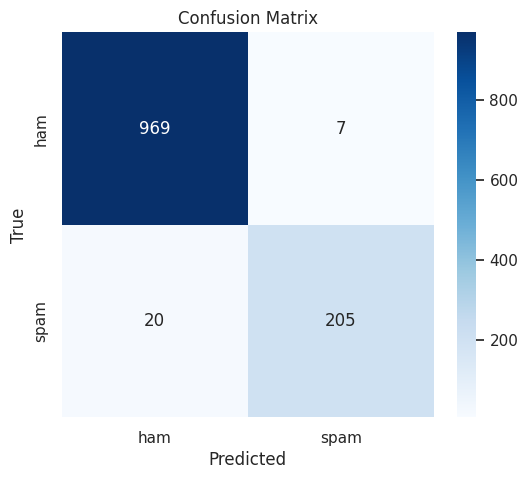

In [ ]:
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Menyimpan model
torch.save(model_blstm.state_dict(), 'bert_lstm_model.pth')

In [ ]:
# Memuat model yang disimpan
model_blstm = BERT_LSTM_Model(bert_model_name='bert-base-uncased', hidden_dim=128, num_classes=2).to(device)
model_blstm.load_state_dict(torch.load('bert_lstm_model.pth'))
model_blstm.eval()  # Pastikan model dalam mode evaluasi

BERT_LSTM_Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [ ]:
# Fungsi untuk prediksi kategori
def predict_blstm(text, model, tokenizer, max_len=32):
    # Tokenisasi input
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    token_type_ids = encoding['token_type_ids'].to(device)

    # Lakukan prediksi
    with torch.no_grad():
        logits = model(input_ids, attention_mask, token_type_ids)

    # Prediksi kelas
    prediction = torch.argmax(logits, dim=1).item()
    print(prediction)

    return 'spam' if prediction >= 0.5 else 'ham'

In [ ]:
data_dummy_spam = [
        "Selamat! Anda telah memenangkan hadiah undian sebesar 10 juta rupiah. Hubungi kami di nomor ini atau kunjungi www.hadiah-anda-gratis.com segera.",
        "Dapatkan diskon eksklusif hingga 80% untuk produk pilihan kami hanya hari ini. Kunjungi www.promohariini.com untuk info lebih lanjut.",
        "Ayo tingkatkan peluang Anda memenangkan hadiah besar dengan mengikuti survei singkat kami. Klik tautan www.kesempatanemas.com sekarang!",
        "Penawaran spesial terbatas! Dapatkan pinjaman hingga 100 juta tanpa jaminan. Kirim informasi Anda melalui SMS ke 123456 untuk pengajuan cepat.",
        "Liburan impian Anda menunggu! Pesan sekarang dan nikmati potongan harga besar dengan hanya sekali klik di www.liburangratis.com.",
        "Peringatan! Akun Anda terdeteksi aktivitas mencurigakan. Segera perbarui informasi dengan klik www.keamananakun.com agar tetap aman.",
        "Mau gadget baru? Ikuti program undian kami dan menangkan smartphone impian Anda! Hubungi kami di nomor ini segera.",
        "Jangan lewatkan promo spesial akhir tahun kami! Gratis ongkos kirim untuk semua pembelian hari ini saja. Pesan sekarang di www.promo-gratis.com.",
        "Tingkatkan kesehatan Anda dengan produk herbal berkualitas. Promo diskon hingga 50% hanya tersedia di www.herbalpilihan.com.",
        "Kami telah memilih Anda sebagai pemenang hadiah eksklusif! Segera isi formulir klaim di www.hadiahkhusus.com sebelum batas waktu habis."
    ]
# Contoh uji prediksi dengan data dummy
for text in data_dummy_spam:
    prediction = predict_blstm(text, model_blstm, tokenizer)
    print(f"Predicted Class: {prediction}")

0
Predicted Class: ham
0
Predicted Class: ham
0
Predicted Class: ham
0
Predicted Class: ham
0
Predicted Class: ham
0
Predicted Class: ham
0
Predicted Class: ham
0
Predicted Class: ham
0
Predicted Class: ham
0
Predicted Class: ham


## Dump

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model.compile(optimizer = "adam",
              loss = 'binary_crossentropy',
              metrics = ["accuracy"])
model.summary()

Model: "tf_bert_for_sequence_classification_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_452 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Build the model
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))

# Second Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output of the convolutional layers
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(128, activation='relu'))

# Output Layer (Binary classification: cat or not)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


In [ ]:
model.fit(train_dataset.batch(16),
          epochs=10,
          # validation_data=test_dataset.batch(32)
          )

Epoch 1/10
115/115 [==============================] - 60s 218ms/step - loss: 7.6284 - accuracy: 0.4878
Epoch 2/10
115/115 [==============================] - 24s 207ms/step - loss: 7.8029 - accuracy: 0.4883
Epoch 3/10
115/115 [==============================] - 24s 206ms/step - loss: 7.8029 - accuracy: 0.4883
Epoch 4/10
115/115 [==============================] - 24s 208ms/step - loss: 7.8029 - accuracy: 0.4883
Epoch 5/10
115/115 [==============================] - 24s 207ms/step - loss: 7.8029 - accuracy: 0.4883
Epoch 6/10
115/115 [==============================] - 24s 207ms/step - loss: 7.8029 - accuracy: 0.4883
Epoch 7/10
115/115 [==============================] - 24s 212ms/step - loss: 7.8029 - accuracy: 0.4883
Epoch 8/10
115/115 [==============================] - 24s 208ms/step - loss: 7.8029 - accuracy: 0.4883
Epoch 9/10
115/115 [==============================] - 24s 206ms/step - loss: 7.8029 - accuracy: 0.4883
Epoch 10/10
115/115 [==============================] - 24s 207ms/step - l

In [ ]:
# Evaluasi Model
loss, accuracy = model.evaluate(test_dataset.batch(32))
print("Akurasi:", accuracy)
print("Loss:", loss)

15/15 [==============================] - 5s 127ms/step - loss: 6.9285 - accuracy: 0.5457
Akurasi: 0.5456521511077881
Loss: 6.928457260131836


In [ ]:
from sklearn.metrics import classification_report

# Prediksi label
y_pred = model.predict(test_dataset.batch(32))
y_pred_classes = (y_pred.logits[:, 1] > 0.5).astype(int)

# Evaluasi metrik
print(classification_report(test_labels, y_pred_classes, target_names=["Ham", "Spam"]))


15/15 [==============================] - 2s 127ms/step
              precision    recall  f1-score   support

         Ham       0.00      0.00      0.00       209
        Spam       0.55      1.00      0.71       251

    accuracy                           0.55       460
   macro avg       0.27      0.50      0.35       460
weighted avg       0.30      0.55      0.39       460



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
